In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1153).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (352).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (179).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (672).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (501).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (405).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (436).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (883).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (564).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (936).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (837).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (421).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1031).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (221).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVI

In [4]:
!pip install split-folders
import tensorflow as tf
import cv2, pathlib, splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
epochs = 50
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)


In [6]:

def create_data_binary(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='Imgs/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range = 10,
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    samplewise_center = True,
    samplewise_std_normalization = True 
    )
    train_ds = data_gen.flow_from_directory('Imgs/train/', target_size=(img_height, img_width),
                                            class_mode='binary', batch_size=batch_size, subset='training')
    test_ds = data_gen.flow_from_directory('Imgs/test/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)

    return train_ds ,test_ds


train_data, test_data = create_data_binary('/kaggle/input/sarscov2-ctscan-dataset/')

Copying files: 2481 files [00:11, 209.83 files/s]


Found 1736 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


In [7]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten,Conv2D,Dropout,BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
import tensorflow as tf

# Load ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
# Add new classifier layers on top of the pre-trained model
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(512, activation = 'LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation = 'LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model_resnet = tf.keras.models.Model(
    inputs = resnet.input, 
    outputs = x
)
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
for layer in model_resnet.layers[:120]:
    layer.trainable = False

In [11]:
optimizer = Adam(learning_rate= 0.001)
model_resnet.compile(optimizer=optimizer, loss = 'binary_crossentropy' ,metrics=['accuracy'])

In [10]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
# Train the models
history_resnet = model_resnet.fit(train_data,
                       validation_data = test_data,
                       epochs=epochs,batch_size= 16,
                       callbacks = [
                           tf.keras.callbacks.EarlyStopping(
                               patience = 5, monitor = 'val_loss', mode = 'min', 
                               restore_best_weights = True
                           ),
                           tf.keras.callbacks.ReduceLROnPlateau(
                               patience = 2, monitor = 'val_loss', 
                               mode = 'min', factor = 0.1
                           )
                       ])

Epoch 1/50
55/55 [==============================] - 57s 782ms/step - loss: 0.7201 - accuracy: 0.6786 - val_loss: 24.8624 - val_accuracy: 0.5053 - lr: 0.0010
Epoch 2/50
55/55 [==============================] - 38s 691ms/step - loss: 0.4711 - accuracy: 0.7840 - val_loss: 2.5446 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 3/50
55/55 [==============================] - 39s 711ms/step - loss: 0.4233 - accuracy: 0.8088 - val_loss: 0.6828 - val_accuracy: 0.8209 - lr: 0.0010
Epoch 4/50
55/55 [==============================] - 38s 686ms/step - loss: 0.3853 - accuracy: 0.8289 - val_loss: 1.8308 - val_accuracy: 0.6043 - lr: 0.0010
Epoch 5/50
55/55 [==============================] - 38s 698ms/step - loss: 0.3675 - accuracy: 0.8422 - val_loss: 0.6483 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 6/50
55/55 [==============================] - 39s 702ms/step - loss: 0.3107 - accuracy: 0.8664 - val_loss: 0.4403 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 7/50
55/55 [==============================] - 39s 707ms/s

In [14]:
loss_resnet, acc_resnet = model_resnet.evaluate(test_data)

12/12 [==============================] - 7s 548ms/step - loss: 0.1577 - accuracy: 0.9439


In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [16]:
def create_charts(cnn, cnn_model):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = test_data.classes
    Y_pred = cnn.predict_generator(test_data, steps = len(test_data))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='Resnet50 (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


[Summary Statistics]
Accuracy = 96.26% | Precision = 97.24% | Recall = 95.14% | Specificity = 97.35% | F1 Score = 96.17%


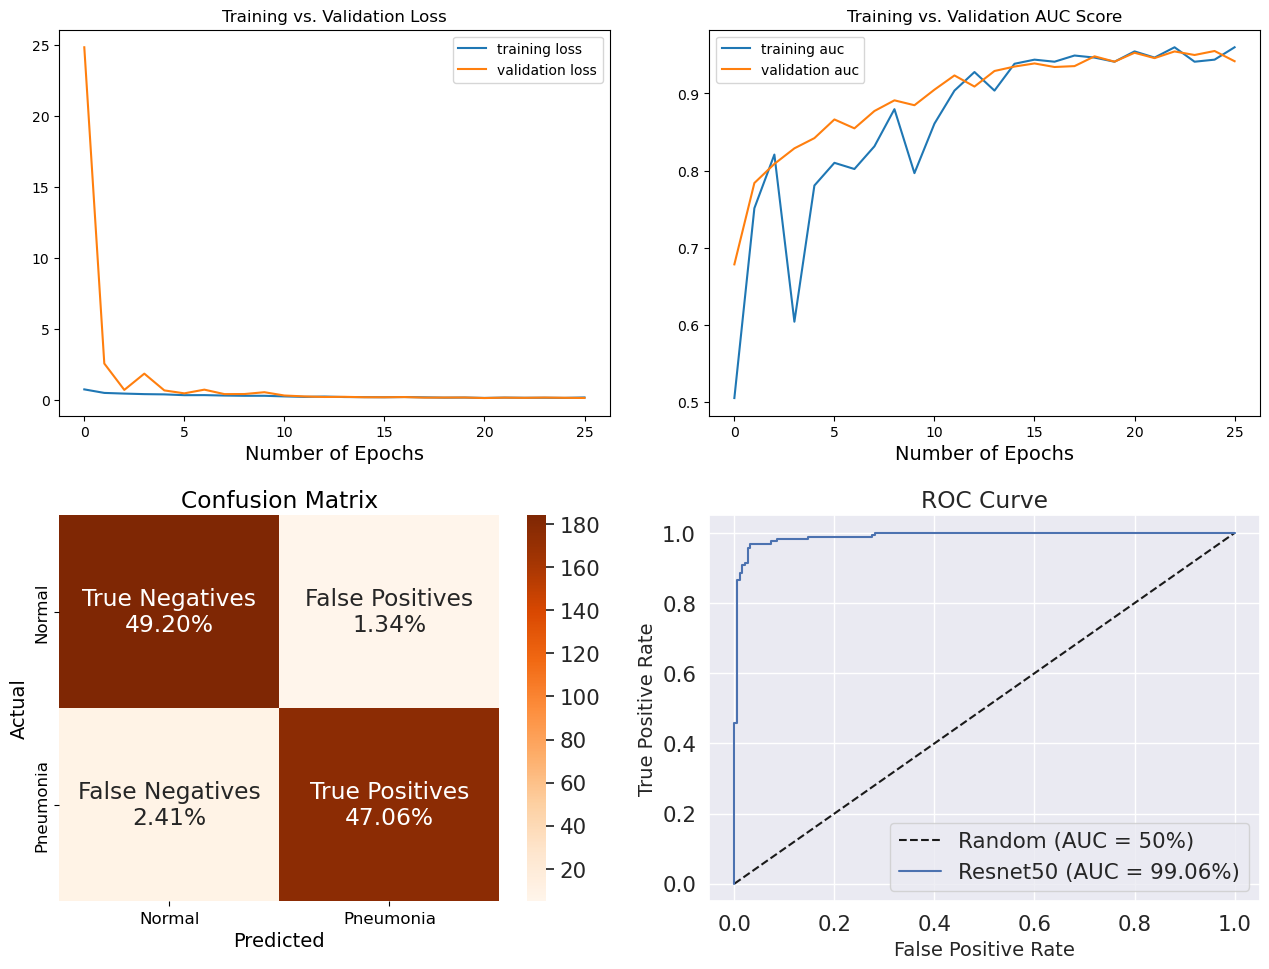

In [17]:
create_charts(model_resnet, history_resnet)

In [18]:
model_resnet.save('Covid-19 X-ray.h5')